In [41]:
import pandas as pd 
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [53]:
#meta_data = pd.read_csv("..\Data\Data_description.xlsx", encoding= 'latin', sep = ';')
meta_data = pd.read_excel("../Data/Data_description.xlsx")

substrate = 'Acetone_d6'
files_list = meta_data[['File', 'Substrate_name']]


In [61]:
def visualize_sum( filename:str, threshold = 0 ):
    data = pd.read_csv(f"../Data/{filename}")

    # sum up all spectra
    sum_spec = pd.DataFrame()
    sum_spec['chem_shift'] = data.iloc[:, 0] #data['Unnamed: 0']
    sum_spec['Intensity_sum']= data.iloc[:, 1:].sum(axis=1)

    # create linegraph
    plt.figure(figsize=(10, 6))
    sns.lineplot(sum_spec, x= 'chem_shift', y= 'Intensity_sum')

    # create vertical line for threshold
    plt.axhline(threshold, color="red", linewidth=0.5)


In [62]:
files_list.Substrate_name.unique()

array(['Acetone-d6', 'Fumarate-d2', 'Nicotinamide-d4',
       'Nicotinamide-d4+ pyruvate (500mM)',
       'Nicotinamide-d4+ pyruvate (400mM)',
       'Nicotinamide-d4+ pyruvate (300mM)',
       'Nicotinamide-d4+ pyruvate (200mM)',
       'Nicotinamide-d4+ pyruvate (100mM)',
       'Nicotinamide-d4+ pyruvate (50mM)',
       'Nicotinamide-d4+ pyruvate (10mM)', 'Pyruvate-d3 '], dtype=object)

In [68]:

def substrate_spectra(substrate, threshold = 0):
    filtered_files = files_list[files_list['Substrate_name'] == substrate]['File']

    for filename in filtered_files:
        visualize_sum(filename, threshold)

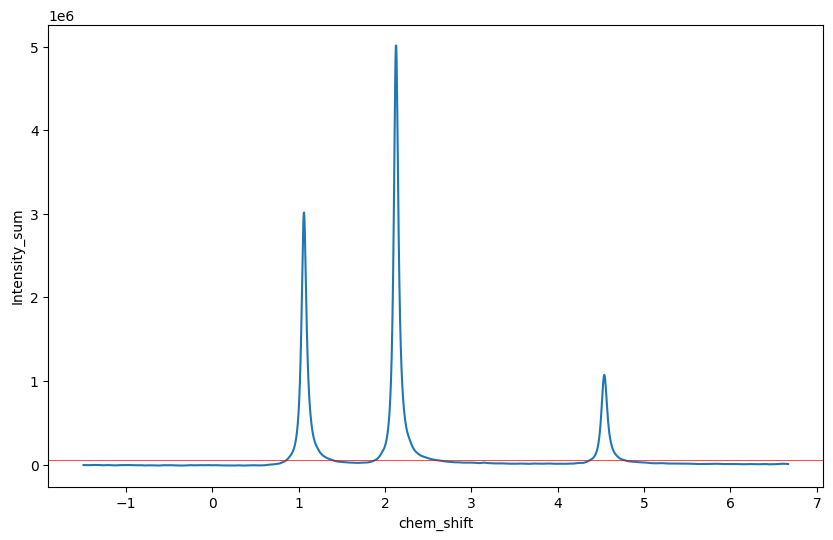

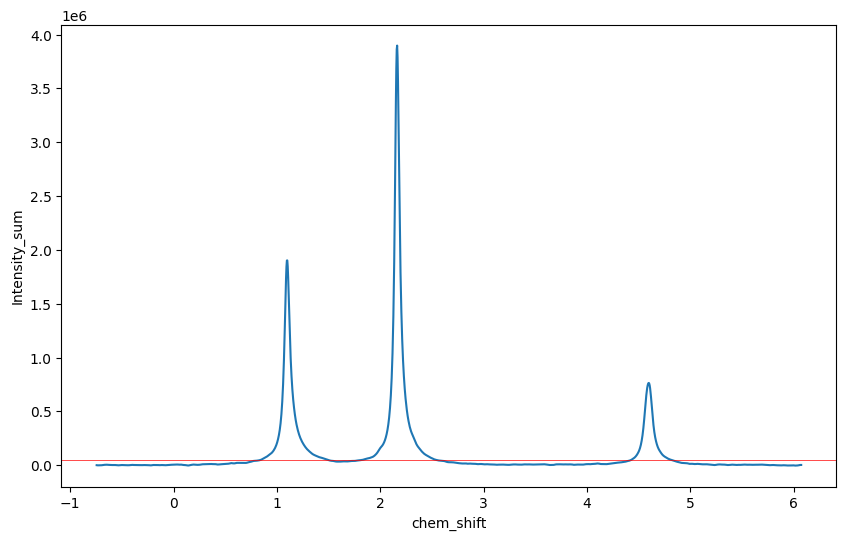

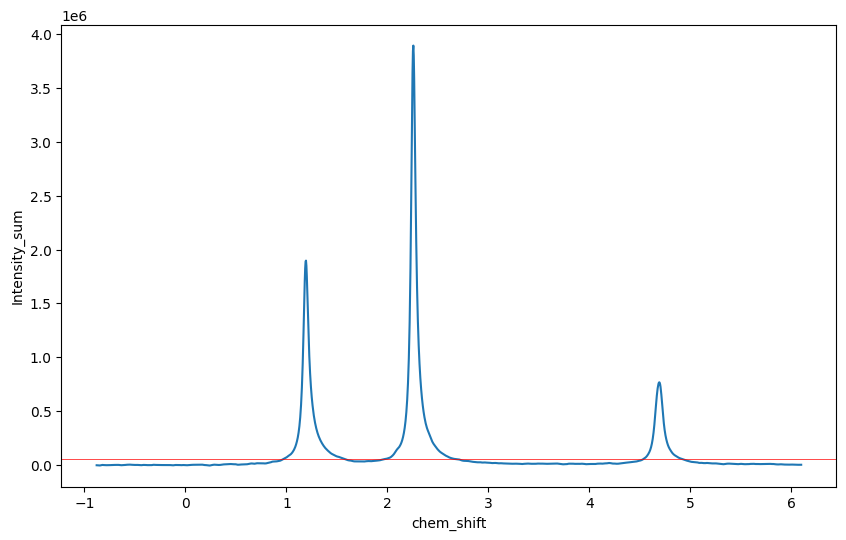

In [72]:
substrate_spectra('Acetone-d6',0.05e6 )

FileNotFoundError: [Errno 2] No such file or directory: '../Data/FA_20240715_2H_yeast_fumarate-d2_3.csv'

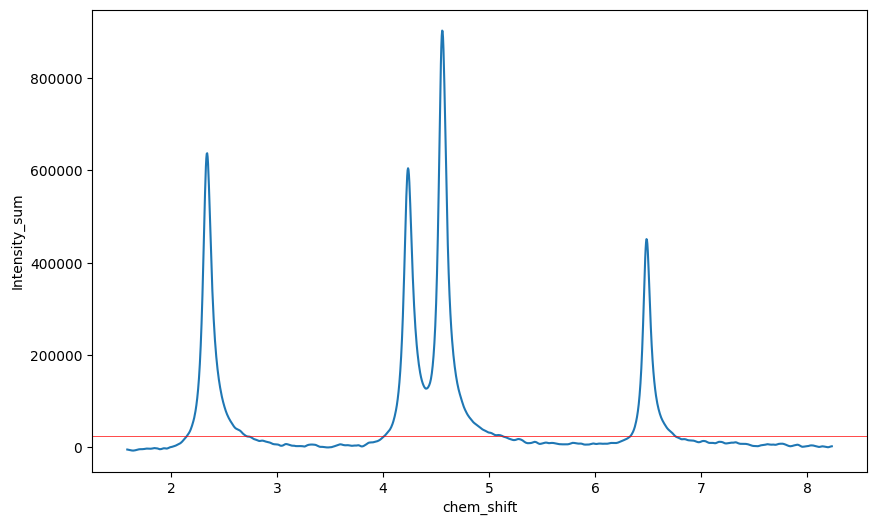

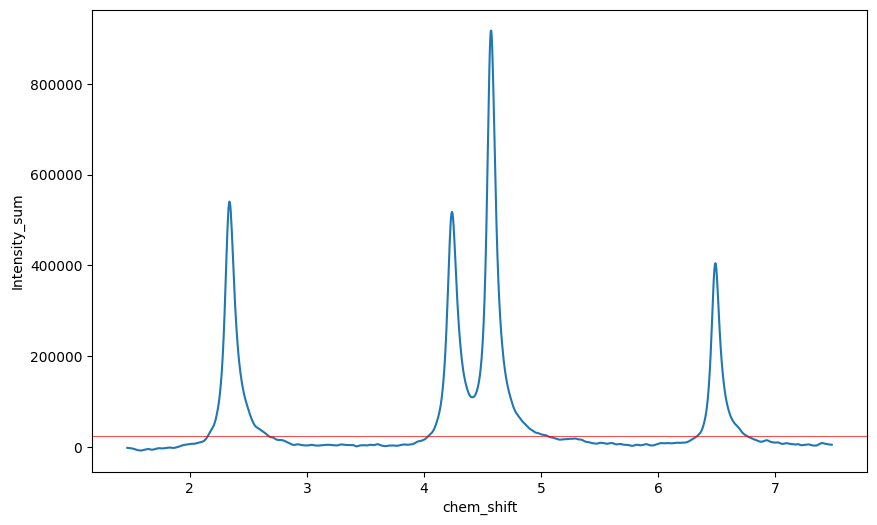

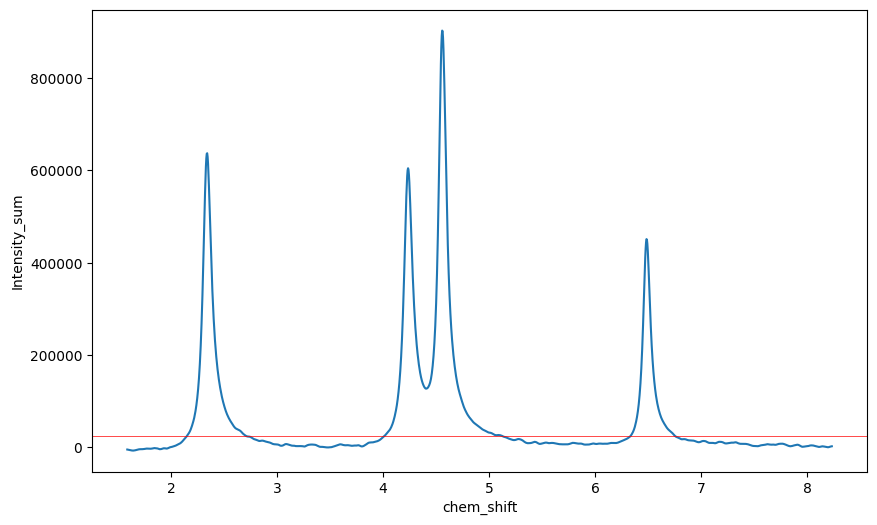

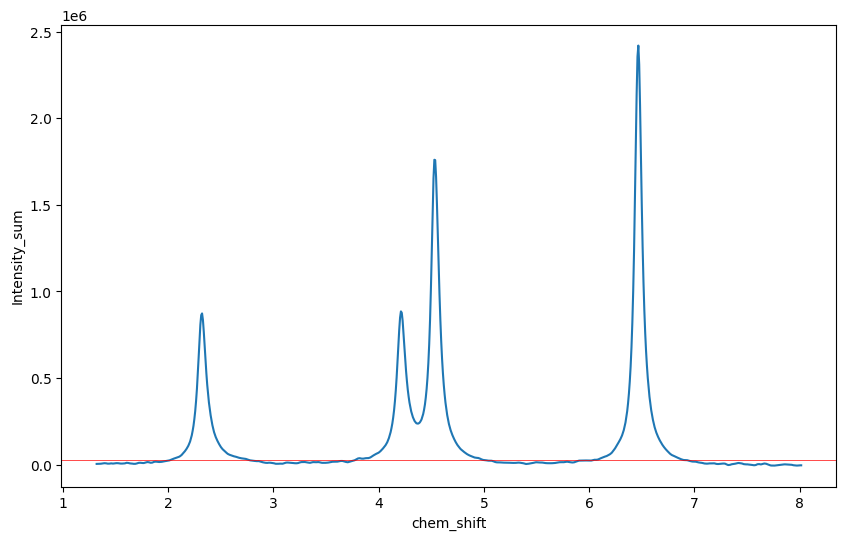

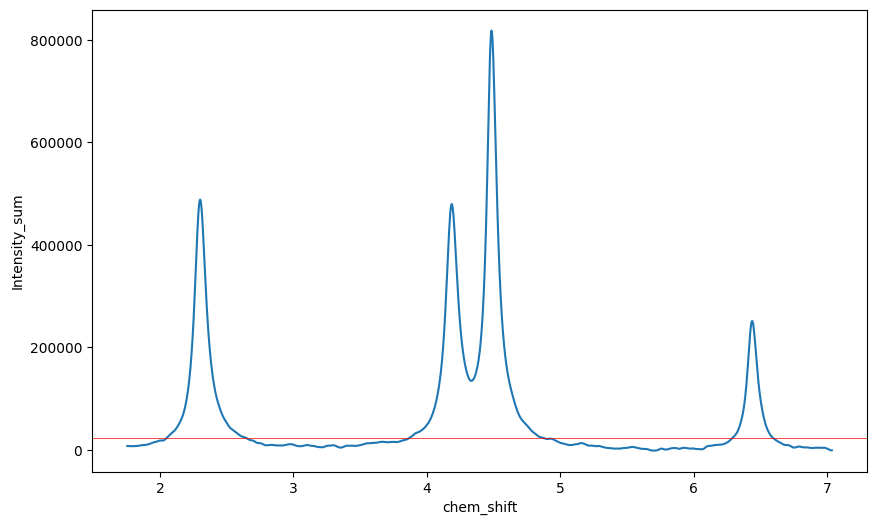

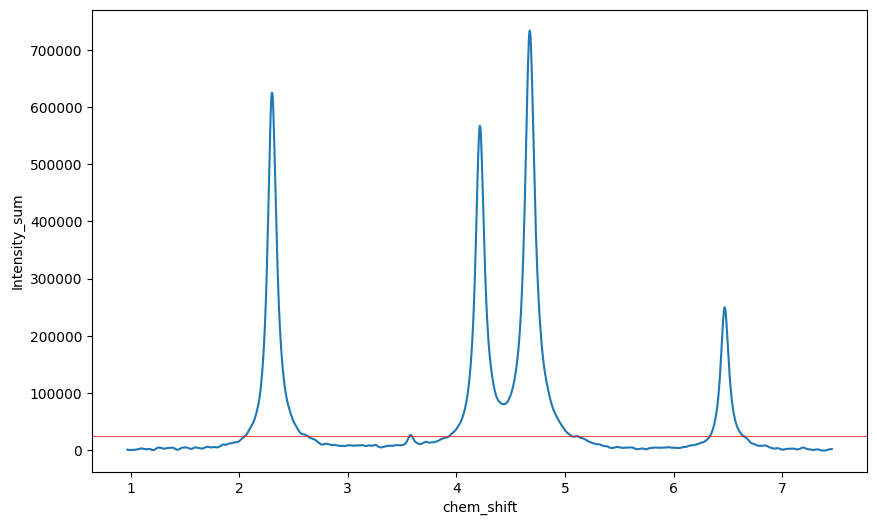

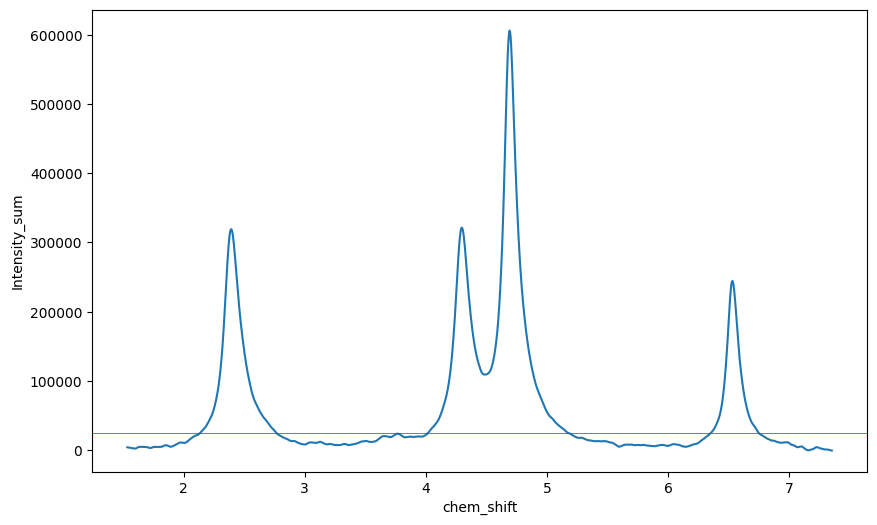

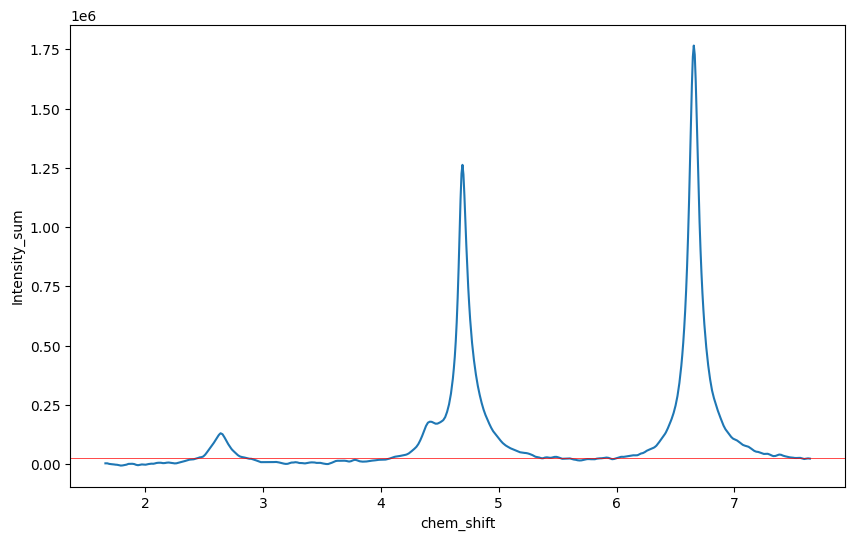

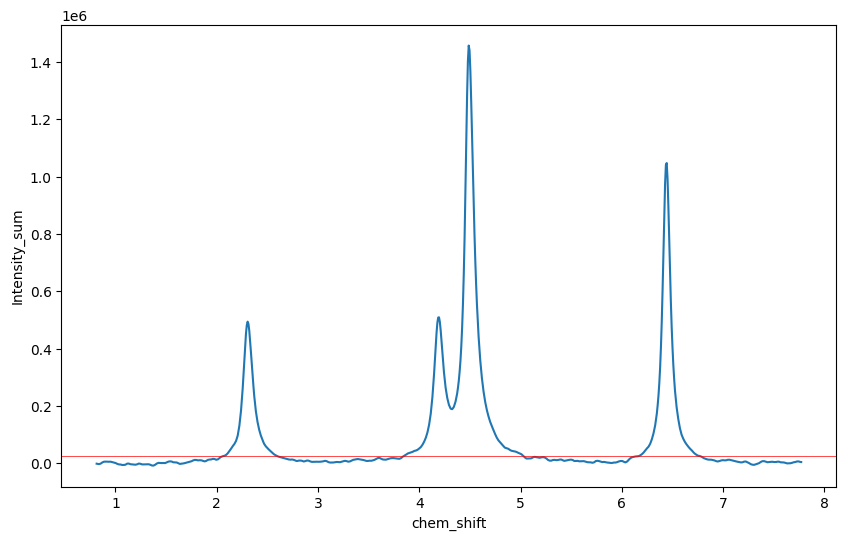

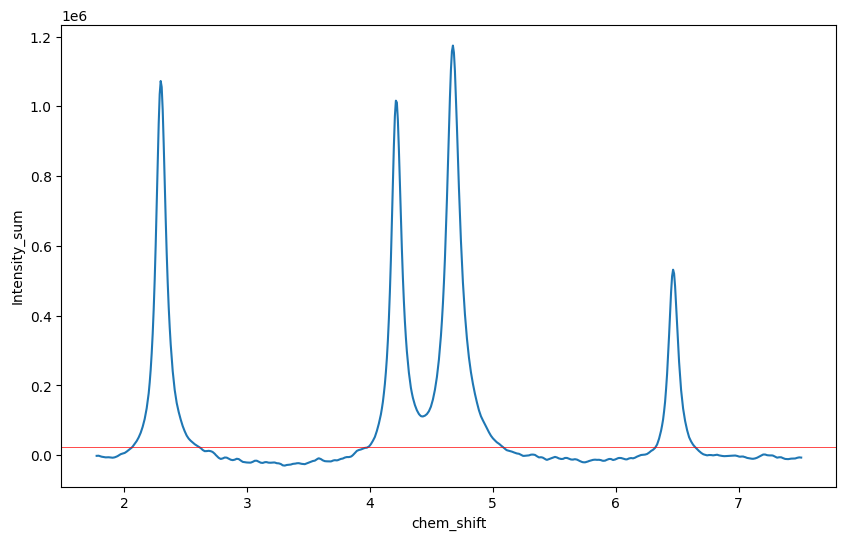

In [78]:
substrate_spectra('Fumarate-d2',0.024e6 )

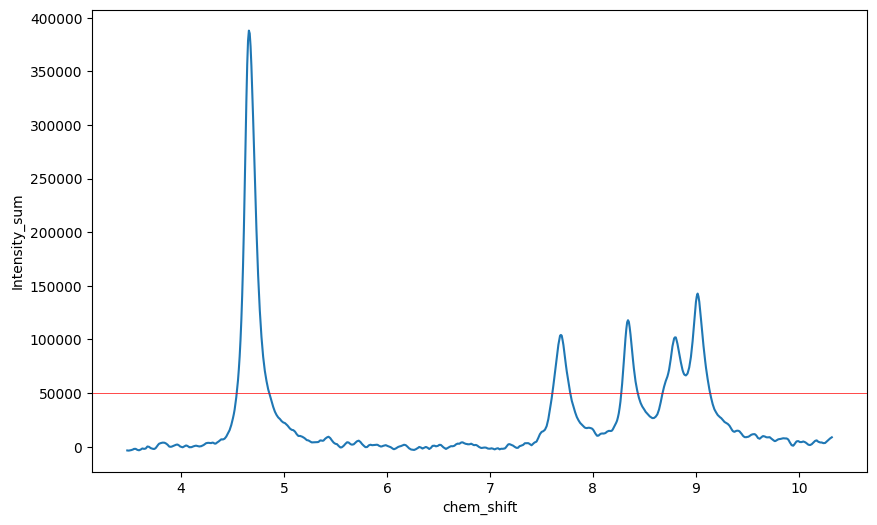

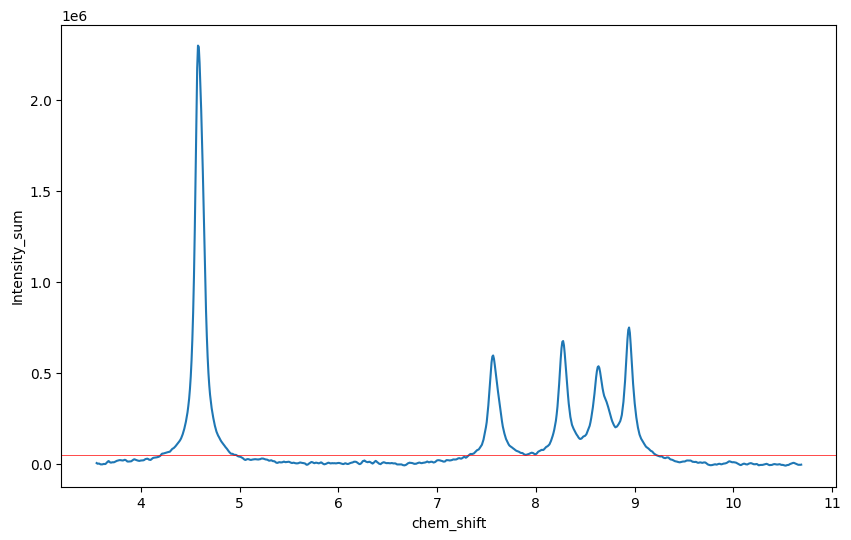

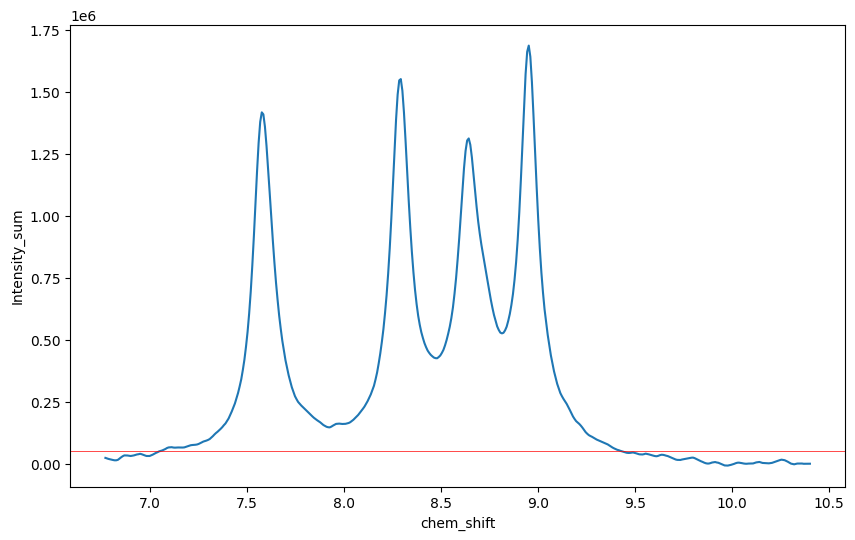

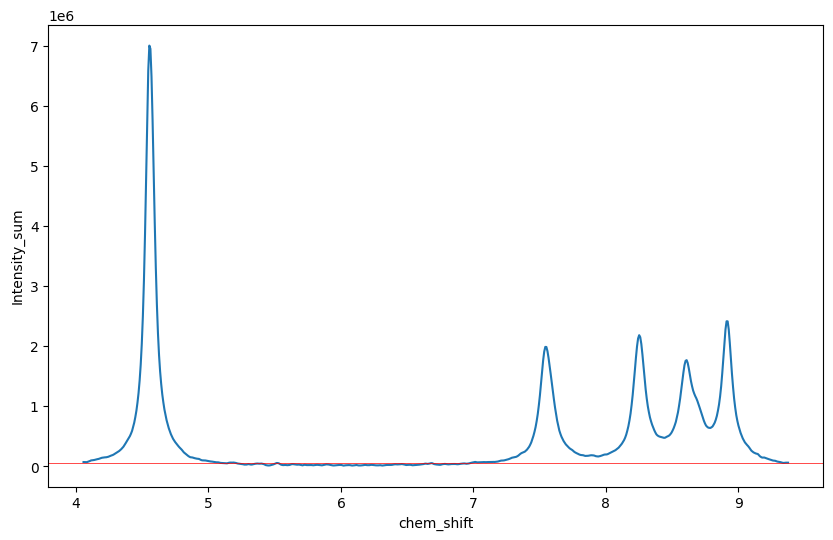

In [80]:
substrate_spectra('Nicotinamide-d4',0.05e6 )

#--> inconsistent threshold needed
# spectra are very variable

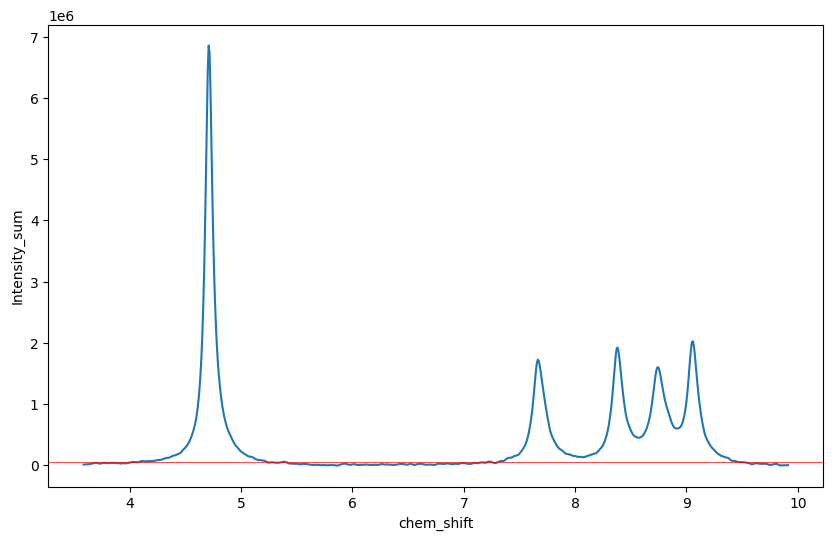

In [81]:
substrate_spectra('Nicotinamide-d4+ pyruvate (500mM)',0.05e6 )

other Nicotinamide pyruvates not checken

In [82]:
substrate_spectra('Pyruvate-d3 ',0.05e6 )

FileNotFoundError: [Errno 2] No such file or directory: '../Data/FA_20231113_2H_yeast_pyruvate-d3_1.csv'

--> threshold for 'smoothing' is difficult to set, since some peaks are very low
--> different threshold for different substrate?

try:
calculate derivate
set all values where summed up spectra is below threshold to zero
calculate 
- calculate minima in 2nd derivative
